# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
from collections import deque
import warnings
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from calibration import Calibration
from utils import *
from preprocessing import *

In [2]:
# sample images
test_images = glob.glob('test_images/*.jpg')
video_images = glob.glob('test_images/video_samples/*.jpg')
project_images = glob.glob('test_images/video_samples/project*.jpg')
challange_images = glob.glob('test_images/video_samples/challange*.jpg')
harder_challange_images = glob.glob('test_images/video_samples/harder_challange*.jpg')

In [3]:
cal = Calibration(nx=9, ny=6)
cal.compute_cal('camera_cal/calibration*.jpg')
M, M_inv = get_prespective_transform(ROI_SRC, ROI_DST)

Loaded camera config from file: calibration.pkl


In [4]:
def process_img(img):
    # undistort
    dst = cal.undistort(img)    
    # color threshold 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_mask = or_masks(color_threshold_image3(hls, HLS_THRESHOLD[0]), 
                        color_threshold_image3(hls, HLS_THRESHOLD[1]))
    # gradient threshold
    red_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    gradient_mask = gradient_threshold(red_channel, kernel_size=GRADIENT_KERNEL_SIZE, 
                                       thresholds=GRADIENT_THRESHOLD)
    # combine thresholds
    mask = or_masks(hls_mask, gradient_mask)
    # roi
    mask = roi(mask, ROI_SRC)
    # warp image
    warped = warp_image(mask, M)
    return warped

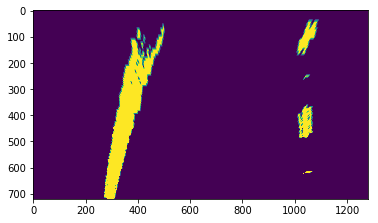

In [5]:
plt.imshow(process_img(mpimg.imread(test_images[0])))

## Lane detection

In [6]:
def find_lane_pixels(img, nwindows=9, margin=150, minpix=50):
    '''
    Searches mask image for lanes
    '''
    # Create histogram of image binary activations
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty), (rightx, righty)

def search_around_poly(mask, left_fit, right_fit, margin=100):
    '''
    search for lane around a poly line
    '''
    # Grab activated pixels
    nonzero = mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return (leftx, lefty), (rightx, righty)


def fit_polynomial(x, y):
    '''
    fit line to pixels
    '''
    # Fit a second order polynomial to each using `np.polyfit`
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            return np.polyfit(y, x, 2)
        except np.RankWarning:
            return None

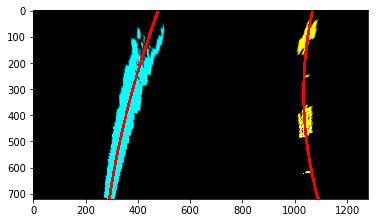

In [7]:
# test lane points

img = mpimg.imread(test_images[0])
mask = process_img(img)
left_points, right_points = find_lane_pixels(mask)

left_lane = fit_polynomial(left_points[0], left_points[1])
right_lane = fit_polynomial(right_points[0], right_points[1])
plt.imshow(plot_lane_lines(mask, left_points, left_lane, right_points, right_lane))

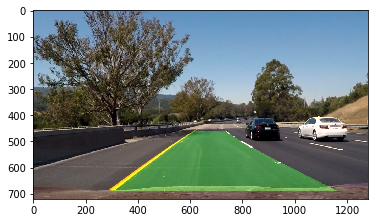

In [8]:
lane_image = draw_lanes(img, left_lane, right_lane, M_inv)
# Combine the result with the original image
result = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
plt.imshow(result)

## Smoothing lanes 

In [9]:
class LaneHistory:
    def __init__(self, history_steps=25, error_limit=100):
        self.lines = deque(maxlen=history_steps)
        self.smoothed_line = None
        self.diff = []
        self.error_limit = error_limit
        
    def append(self, line):
        if line is None:
            return False
        if self.smoothed_line is not None:
            if self.error(line) > self.error_limit:
                # bad line don't use
                return False
        self.lines.append(line)
        self.compute_average()
        return True
    
    def compute_average(self):
        if len(self.lines) == 0:
            return
        else:
            self.smoothed_line = np.mean(self.lines, axis=0)
            
    def get_line(self):
        return self.smoothed_line
    
    def error(self, line):
        return np.absolute(self.norm(line) - self.norm(self.smoothed_line))
    
    def norm(self, x):
        return np.sqrt(x[0]**2+x[1]**2+x[2]**2)
    
def measure_curvature(y, line_eq):
    '''
    Calculates the curvature of polynomial functions.
    '''
    # calculation of R_curve (radius of curvature)
    return ((1 + (2*y*line_eq[0]+line_eq[1])**2)**(3/2))/np.absolute(2*line_eq[0])

def cvt_line_to_meters(line_eq, xm, ym):
    '''
    cvt line from pixels to meters
    '''
    new_line = np.copy(line_eq)
    new_line[0] *= xm/(ym**2)
    new_line[1] *= xm/ym
    return new_line

def eval_point_at_line(y, line):
    return line[0]*(y**2) + line[1]*y + line[2] 

def offset(y, width, xm, left_line, right_line):
    left_x = eval_point_at_line(y, left_line)
    right_x = eval_point_at_line(y, right_line)
    return (((left_x+right_x)/2)-(width/2))*xm

Test

Full search
Offset: 0.25828035999047044
Curvature left: 844.4088583930572  right:3411.363797207521


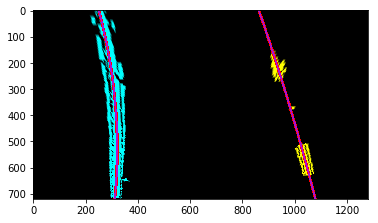

Offset: 0.22270821129894824
Curvature left: 960.6543269275567  right:1595.4417340854568


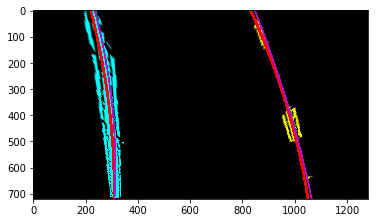

Offset: 0.22543785229713065
Curvature left: 983.8226572669511  right:1280.4751369383146


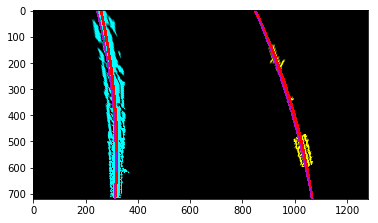

Offset: 0.20221468208209192
Curvature left: 949.062599750386  right:895.6686647154019


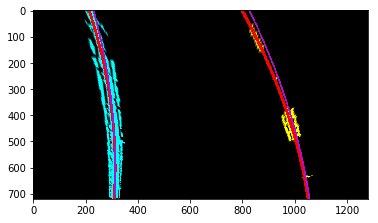

Offset: 0.19213677899143944
Curvature left: 875.3234586403033  right:890.2257367217481


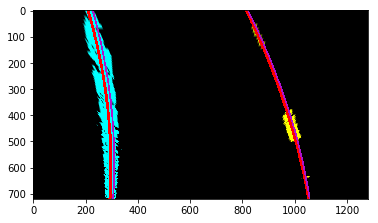

Offset: 0.1507123632158643
Curvature left: 895.4460634131838  right:970.9602413154549


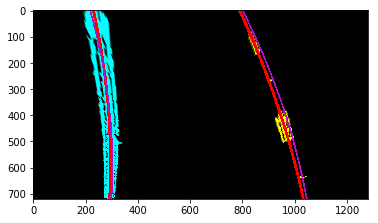

Offset: 0.13514549169413995
Curvature left: 845.2593872378152  right:937.7725405070718


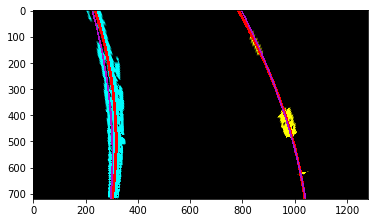

Offset: 0.08900489375809126
Curvature left: 804.4771292774834  right:888.5445990751057


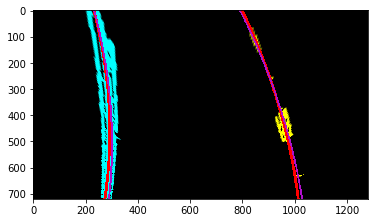

Offset: 0.12244251682595893
Curvature left: 833.4698342983473  right:848.8569383254539


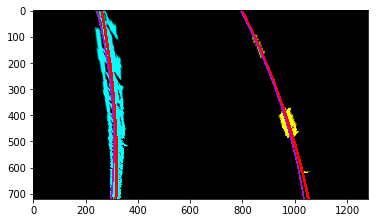

Offset: 0.10709752000226927
Curvature left: 979.9444828335664  right:887.0717059760696


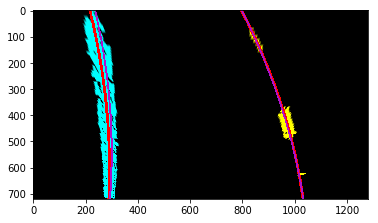

In [10]:
# pixels to meters
xm = 3.7/800
ym = 32/720

left_lane = LaneHistory(3)
right_lane = LaneHistory(3)
MIN_POINTS = 4000

for fname in video_images:
    img = mpimg.imread(fname)
    mask = process_img(img)
    
    if left_lane.get_line() is not None and right_lane.get_line() is not None:
        # try search near prev margin
        left_points, right_points = search_around_poly(mask, left_lane.get_line(), right_lane.get_line())
        if len(left_points[0]) < MIN_POINTS or len(right_points[1]) < MIN_POINTS:
            left_points, right_points = find_lane_pixels(mask)
    else:
        left_points, right_points = find_lane_pixels(mask)
        print('Full search')

    left_fit = fit_polynomial(left_points[0], left_points[1])
    left_lane.append(left_fit)
    right_fit = fit_polynomial(right_points[0], right_points[1])
    right_lane.append(right_fit)
    
    # measure 
    print('Offset: {}'.format(offset(720, 1280, xm, left_lane.get_line(), right_lane.get_line())))
    left_c = measure_curvature(720*ym, cvt_line_to_meters(left_lane.get_line(), xm, ym))
    right_c = measure_curvature(720*ym, cvt_line_to_meters(right_lane.get_line(), xm, ym))
    print('Curvature left: {}  right:{}'.format(left_c, right_c))
    
    plt.imshow(plot_lane_lines(mask, left_points, left_fit, right_points, right_fit, left_lane.get_line(), right_lane.get_line()))
    plt.show()

## Complete algorithm

Loaded camera config from file: calibration.pkl


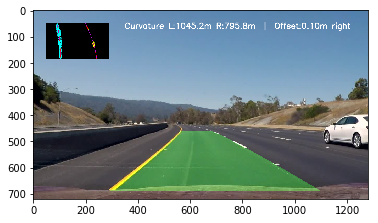

In [11]:
class LaneDetector():
    def __init__(self, xm=3.7/800, ym=32/720, history=10, min_points=4000):
        self.xm = xm
        self.ym = ym
        self.width = None
        self.height = None
        self.min_points = min_points
        self.cal = Calibration(nx=9, ny=6)
        cal.compute_cal('camera_cal/calibration*.jpg')
        self.M, self.M_inv = get_prespective_transform(ROI_SRC, ROI_DST)
        self.left_lane = LaneHistory(history)
        self.right_lane = LaneHistory(history)
        
    def process(self, img, debug=True):
        if self.width is None or self.height is None:
            self.height = img.shape[0]
            self.width = img.shape[1]

        mask = process_img(img)
    
        # find lanes
        if self.left_lane.get_line() is not None and self.right_lane.get_line() is not None:
            # try search near prev margin
            left_points, right_points = search_around_poly(mask, 
                                                           self.left_lane.get_line(), 
                                                           self.right_lane.get_line())
            if len(left_points[0]) < self.min_points or len(right_points[1]) < self.min_points:
                left_points, right_points = find_lane_pixels(mask)
        else:
            left_points, right_points = find_lane_pixels(mask)
        left_fit = fit_polynomial(left_points[0], left_points[1])
        self.left_lane.append(left_fit)
        right_fit = fit_polynomial(right_points[0], right_points[1])
        self.right_lane.append(right_fit)

        # measure 
        offset_m = offset(self.height, self.width, self.xm, 
                          self.left_lane.get_line(), self.right_lane.get_line())
        left_c = measure_curvature(self.height*self.ym, 
                                   cvt_line_to_meters(self.left_lane.get_line(), self.xm, self.ym))
        right_c = measure_curvature(self.height*self.ym, 
                                   cvt_line_to_meters(self.right_lane.get_line(), self.xm, self.ym))
        
        # draw lane image
        lane_image = draw_lanes(img, self.left_lane.get_line(), self.right_lane.get_line(), self.M_inv)
        result = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
        cv2.putText(result, self.get_text_string(offset_m, (left_c, right_c)),
                    (350,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

        if debug:
            debug_img = plot_lane_lines(mask, left_points, left_fit, right_points, right_fit, 
                                        self.left_lane.get_line(), self.right_lane.get_line())
            result = embed_image(result, debug_img)
        return result
        
    def get_text_string(self, offset_m, curvature_m):
        return 'Curvature L:{:.1f}m R:{:.1f}m  |  Offset:{:.2f}m {}'.format(
            curvature_m[0], curvature_m[1], abs(offset_m), 
            'right' if offset_m >= 0 else 'left')
    
l = LaneDetector()
plt.imshow(l.process(img))

## Process project video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
detector = LaneDetector()
clip = VideoFileClip("test_videos/project_video.mp4")
output = clip.fl_image(detector.process)
output.write_videofile('output.mp4', audio=False)

Loaded camera config from file: calibration.pkl
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [05:28<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))